# A Hierarchical Bayesian Regression Model
## A meta-analysis of experimental studies of an education intervention 


## Milad Kharratzadeh

We consider a model with varying slopes, varying intercepts, and individual-level and group-level predictors. We motivate this model for the meta-analysis of experimental studies of an education intervention (e.g., a new coaching program). Assume that the studies were done over $N$ students in $J$ different schools. For each student, a measure of improvement, $y_n$, was achieved (e.g., the score improvment in a test compared to a pre-treatment test). For each student, we have $P$ predictors, ${\bf x}_n$, which could include the socio-economic status of the student, number of study hours, pre-treatment test score, parent's education level, etc. The first element of the predictor vector is 1 (allowing for intercept). We first pose a within-group model of how the individual-level predictors affect the measure of improvement:

$$y_n  \sim   \text{N} ({\bf x}_n^T\boldsymbol{\beta}_{g[n]}, \sigma^2), \qquad n=1, \ldots, N,$$

where $g[n]$ is the group (i.e., school) of the $n$th student. Therefore, we assume that the the coefficient vectors, $\boldsymbol{\beta}_i$, vary across schools. Next, we characterize this variation by using a multi-variate Normal distribution: 

\begin{eqnarray}
\boldsymbol{\beta}_j & \sim &\text{MVN} ({\bf u}_j^T \boldsymbol{\gamma}, \boldsymbol{\Sigma}), \qquad j=1, \ldots, J,
\end{eqnarray}

where ${\bf u}_j$ are the school-level predictors (e.g., size of classrooms or historical performance) , and $\boldsymbol{\gamma}$ is the group-level coefficient matrix. We assign a weakly informative prior, $\text{N}(0,5)$, on the elements of $\boldsymbol{\gamma}$. The covariance matrix is decomposed into a scale and a correlation matrix as follows:

\begin{eqnarray}
\boldsymbol{\Sigma} & = & \text{diag}(\boldsymbol{\tau}) \ \boldsymbol{\Omega} \  \text{diag}(\boldsymbol{\tau}), 
\end{eqnarray}

where $\boldsymbol{\tau}$ are scale coefficients and $\boldsymbol{\Omega}$ is the correlation matrix with the following priors:

\begin{eqnarray}
\boldsymbol{\tau}_i & \sim & \text{Cauchy} (0, 2.5), \quad \boldsymbol{\tau}_i>0, \qquad {weakly \ informative \ prior}, \\
\boldsymbol{\Omega} & \sim & \text{LKJcorr}(2),
\end{eqnarray}

The LKJ prior is for parameter $\nu$ is proportional to $|\text{det}(\boldsymbol{\Omega})|^{\nu-1}$.  As $\nu$ increases, the prior increasingly concentrates around the unit correlation matrix (i.e., favors less correlation among the components of $\boldsymbol{\beta}_i$ ). In Stan, the LKJ prior is applied through the Cholesky decomposition of the correlation matrix.

## Generating Simulated Data

In this notebook, we use simulated data for showcasing how Stan can be used to fit a model to the data and how we can analyse the fit of the model. We use the `generated quantities` block in Stan to generate the data.  

In [3]:
file_path <- "generateData.stan";
lines <- readLines(file_path, encoding="ASCII");
for (n in 1:length(lines)) cat(lines[n],'\n');

data { 
  int<lower=1> J;                     // Number of groups 
  int<lower=1> Q;                     // Number of group-level predictors 
  int<lower=1> N;                     // Number of individuals 
  int<lower=1> P;                     // Number of individual-level predictors 
  int<lower=1, upper=J> gg[N];        // Grouping 
} 
 
parameters { 
} 
 
model { 
} 
 
generated quantities { 
  matrix<lower=0, upper=2>[N, P] X;   // Individual predictors 
  matrix<lower=0, upper=5>[J, Q] U;   // Group predictors 
  real<lower=0> sigma;                // Observation error 
  matrix[Q, P] gamma;                 // Group-level coefficients 
  matrix[P, J] Z;                     // Z will be used later to build Beta 
  vector<lower=0>[P] tau;             // Prior scale 
  cholesky_factor_corr[P] Omega_chol; // Cholesky decomposition of Omega 
  matrix[J, P] Beta;                  // Individual-level coefficients 
  vector[N] Y;                        // Responses 
 
  sigma = 10;  
  fo

Then, in `R`, we call the `stan` function to generate the data from the specified model. The `fixed_param` informs `Stan` not to try to sample or optimize;  it is an alternative way to run `Stan` to just reads in the data and then execute the `generated quantities` block. We pass `iter = 1`, because we want to just get a single draw.    

In [ ]:
library("rstan")
J <- 20                  # Number of groups
Q <- 4                   # Number of group-level predictors
N <- 1000                # Number of individuals
P <- 4                   # Number of individual-level predictors
gg <- rep(1:J, each=N/J) # Group memberships
fit <- stan("generateData.stan", data=c("J","Q","N","P","gg"), algorithm = "Fixed_param", 
            iter = 1, chains = 1, seed=1234)
mfit <- extract(fit)
X <- mfit$X[1,,]  # Individual predictors
U <- mfit$U[1,,]  # Group predictors
Y <- mfit$Y[1,]  # Observed Responses

A summary of the generated data, Y, is shown below by displaying a boxplots of improvments, first for each school, and then against one of the school-level predictors.

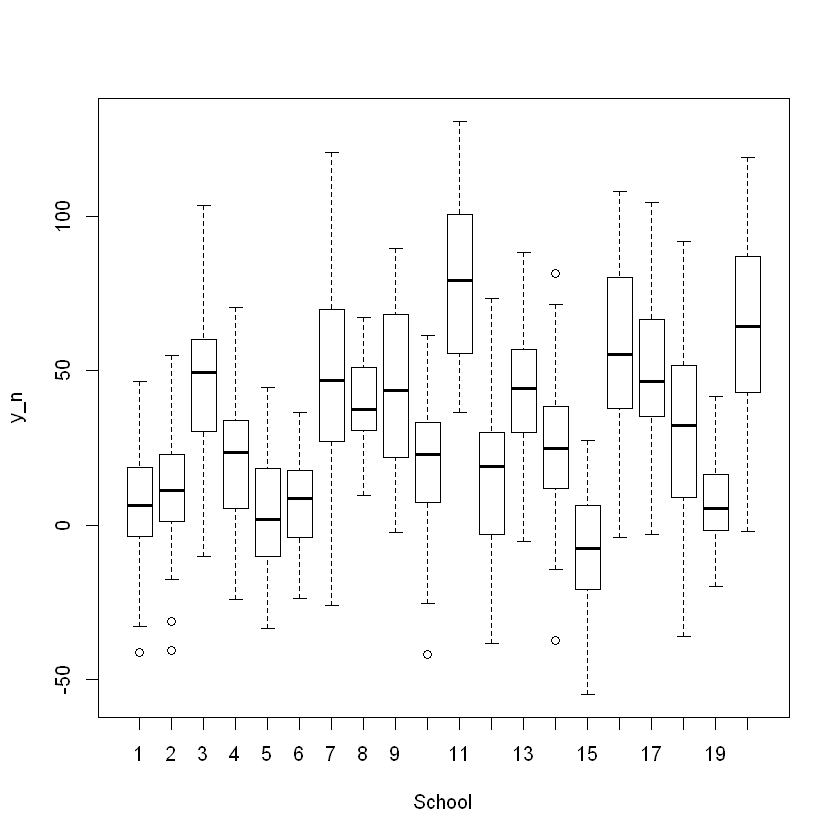

In [5]:
boxplot(matrix(Y,nrow=50),xlab="School", ylab="y_n")

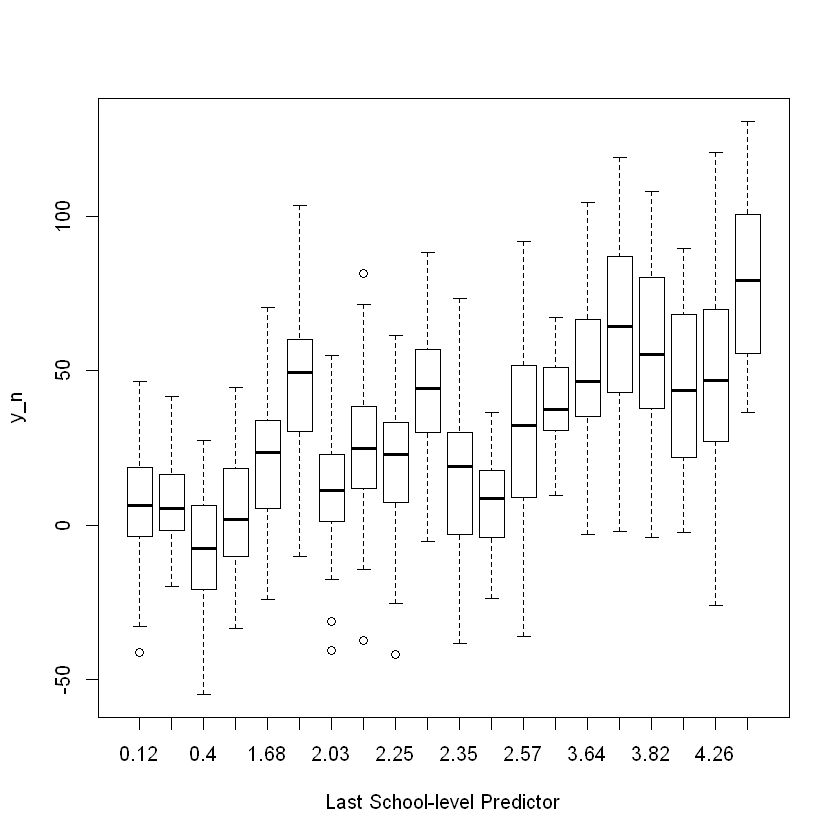

In [6]:
xa <- rep(round(U[,4],2),each=N/J)
boxplot(Y~xa, xlab="Last School-level Predictor", ylab="y_n")

## Fitting the Model

After generating the data, we fit the model using Stan. The Stan code for implementing the above model, with comments, is as follows:

In [7]:
file_path <- "HierarchicalRegression.stan";
lines <- readLines(file_path, encoding="ASCII");
for (n in 1:length(lines)) cat(lines[n],'\n');

data { 
  int<lower=1> J; // Number of groups 
  int<lower=1> Q; // Number of group-level predictors 
  int<lower=1> N; // Number of individuals 
  int<lower=1> P; // Number of individual-level predictors 
  int<lower=1, upper=J> gg[N]; // Grouping 
  matrix[N, P] X; // Individual predictors 
  matrix[J, Q] U; // Group predictors 
  vector[N] Y;    // Responses 
} 
 
parameters { 
  real<lower=0> sigma;    // Observation error 
  matrix[Q, P] gamma;     // Group-level coefficients 
  matrix[P, J] Z;         // Z will be used later to build Beta 
  vector<lower=0>[P] tau; // Prior scale 
  cholesky_factor_corr[P] Omega_chol; // Cholesky decomposition of Omega 
} 
 
transformed parameters { 
  matrix[J, P] Beta;  // Individual-level coefficients 
  Beta = U * gamma + (diag_pre_multiply(tau, Omega_chol) * Z)'; 
} 
 
model { 
  tau ~ cauchy(0,2.5); 
  to_vector(Z) ~ normal(0, 1); 
  Omega_chol ~ lkj_corr_cholesky(2); 
  to_vector(gamma) ~ normal(0, 5); 
  Y ~ normal(rows_dot_product(Beta[g

Now, we are ready to fit the model using the stan function from the library rstan. We run 2 chains of MCMC, each with 1000 iterations (the first 500 iterations of each chain are for warmup). While running, the stan function prints some information about the status of the MCMC; we omit these information in this notebook for brevity. 

In [ ]:
library("rstan")
library("codetools")
fit <- stan("HierarchicalRegression.stan", data=c("J","Q","N","P", "gg", "X","U","Y"), 
            control=list(adapt_delta=0.9, stepsize=0.005), chains=2, iter=1000, seed=1234);

We can print a summary of the fit to examine the estimated posterior confidence intervals for different parameters, the number of effective samples, or the R-hat. The detailed summary of the fit for our model is included in the appendix at the end of this notebook. The high number of effective samples and R-hats equal to 1 (or very close to 1) show that the simulation chains have mixed well. 

## Model Checking

We evaluate the fit of the model by some posterior predictive checks. We start by sampling replicated data from the simulated coefficients:

In [9]:
mod_fit <- extract(fit)         # Extracting the simulated parameters from Stan's output
n_sims <- length(mod_fit$lp__)  # Total number of simulations (after warmup) for each parameter
Yrep <- array(NA, c(n_sims, N)) # The matrix containing replicated data 
for (s in 1:n_sims)
  Yrep[s,] <- rnorm(N,rowSums(X * mod_fit$Beta[s, gg,]), mod_fit$sigma[s]) # Sampling replicated data  

As the first check, we examine the mean and standard deviation of $\{y_n, n=1, \ldots, N\}$. For the original data, we get a mean and a standard deviation. However, for each set of replicated data (each row of Yrep), we get a mean and a standard deviation (n_sims in total). We can plot the distribution of these means and standard deviations and compare them with those of original data. 

For the following plots, we use the package `bayesplot`, wchics provides plotting functions that can be used after fitting Bayesian models in Stan. This package is available for download from the following link: https://github.com/stan-dev/bayesplot. 

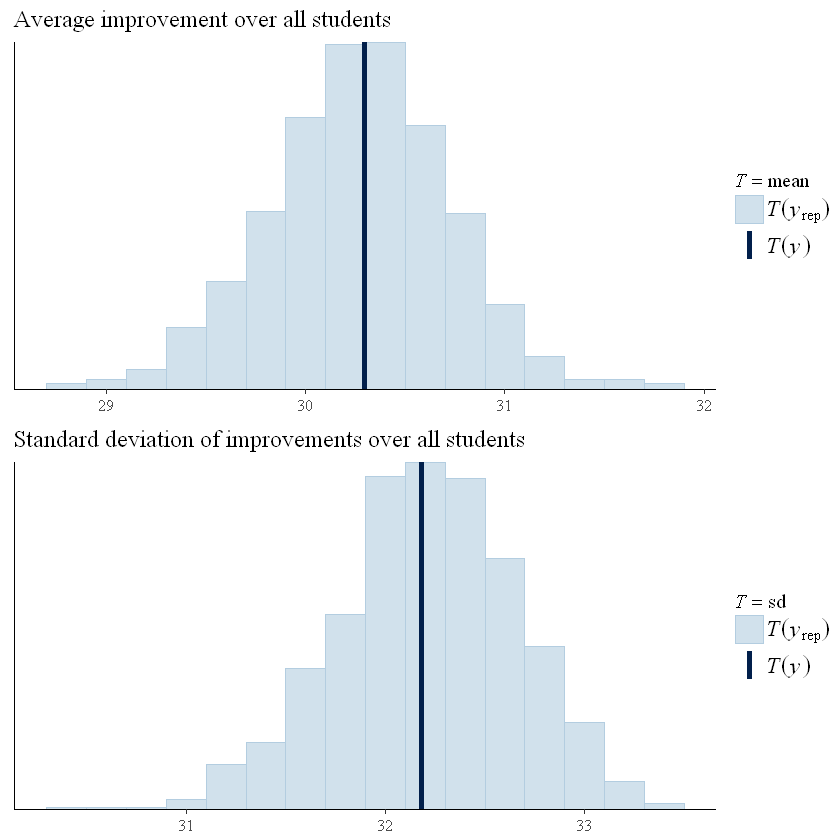

In [16]:
library("bayesplot")
library("ggplot2")
library("cowplot")
library("grid")

plot1 <- ppc_stat(Y, Yrep, stat = "mean",binwidth = 0.2) + 
  ggtitle("Average improvement over all students") 
plot2 <- ppc_stat(Y, Yrep, stat = "sd", binwidth = 0.2) + 
  ggtitle("Standard deviation of improvements over all students") 
plots <- list(plot1, plot2)
grobs <- lapply(plots, ggplotGrob)
gr <-  do.call(gridExtra::rbind.gtable, grobs)
grid.newpage()
grid.draw(gr)

These figures show that the original data is consistent with the replicated data from the fitted model. 

We can also look at the means and standard deviations for each school separately. We can summarize the results for these uni-modal distributions in the figures below. For each school (positioned according to the last school-level predictor), We show the distribution of the replicated data (median 5% and 95% quantiles) and the data for the original data with a dark blue dot. 
These show that our model provides a good fit for the average improvments in each school and also the variattion of improvements within each school. 

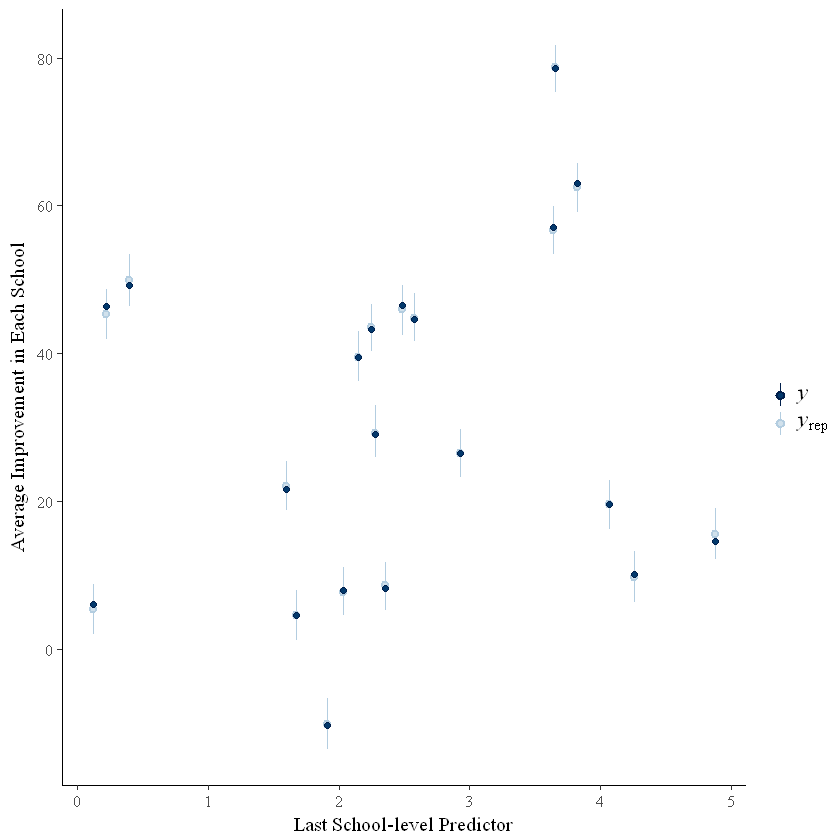

In [15]:
library("bayesplot")
stat <- matrix(NA,1000,J)
for (i in 1:1000)
    stat[i,] <- tapply(Yrep[i,],xa,FUN="mean")
P <- tapply(Y,xa,FUN="mean")
ppc_intervals(P, stat, U[,4], size=0.5, prob = 0.9) + 
    xlab("Last School-level Predictor") + ylab("Average Improvement in Each School")

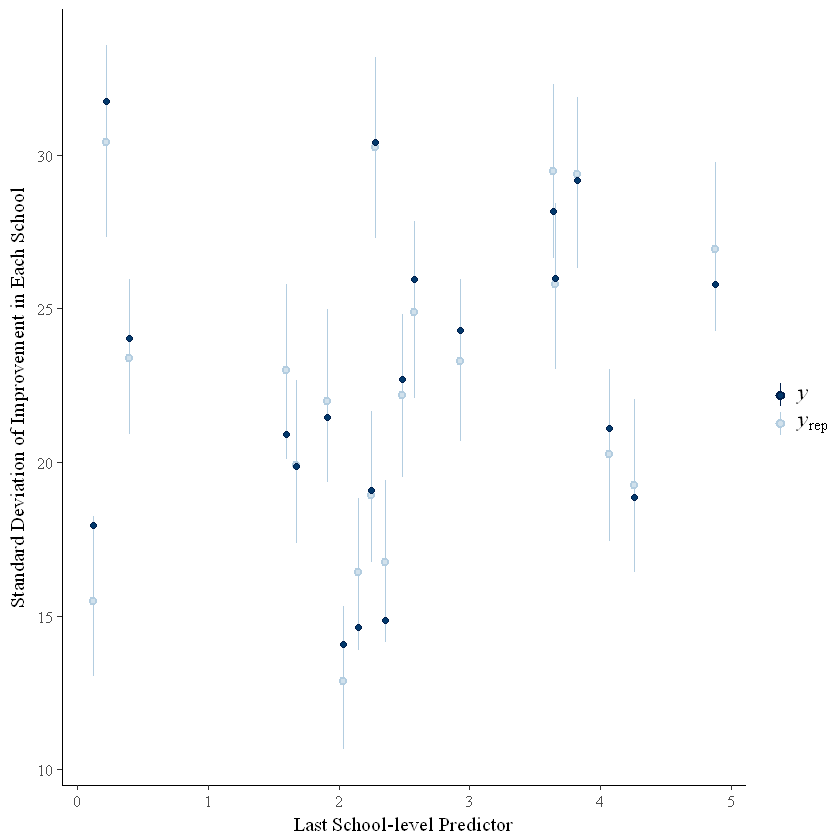

In [14]:
stat <- matrix(NA,1000,J)
for (i in 1:1000)
    stat[i,] <- tapply(Yrep[i,],xa,FUN="sd")
P <- tapply(Y,xa,FUN="sd")
ppc_intervals(P, stat, U[,4], size=0.5, prob = 0.9) + 
    xlab("Last School-level Predictor") + ylab("Standard Deviation of Improvement in Each School")

Finally, for each school, we show scatterplots of the actual improvements versus the average improvements in the replicated data. These show a good alignment betweeb the original and replicated data. 

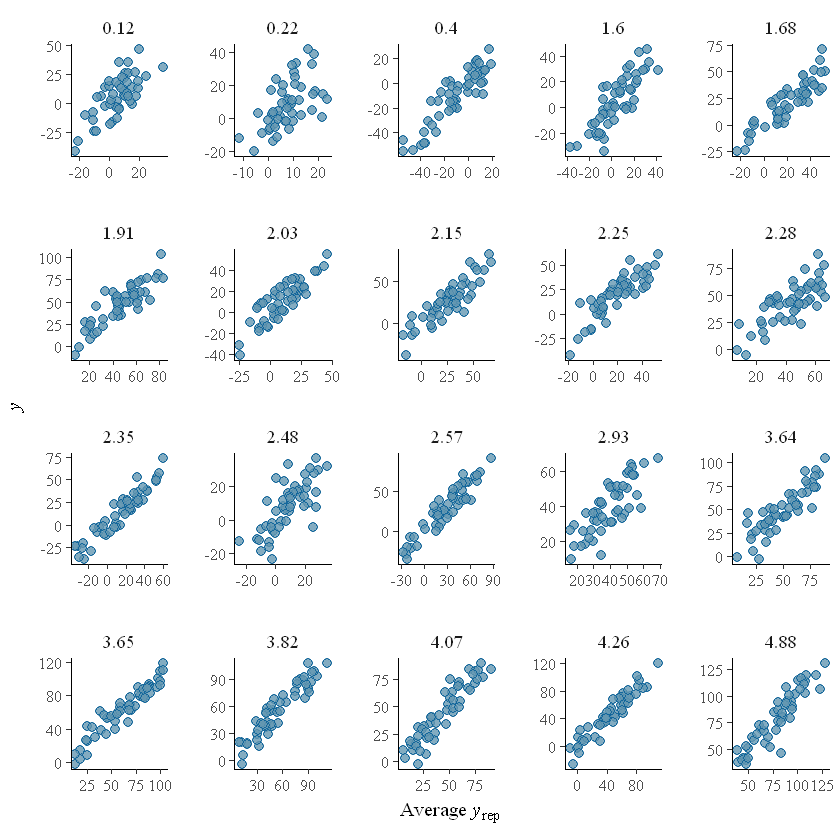

In [17]:
ppc_scatter_avg_grouped(Y,Yrep, group = xa)

## Appendix: Summary of the Fit

In [18]:
options(width="100");
print(fit,digits=2);

Inference for Stan model: HierarchicalRegression.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                    mean se_mean   sd     2.5%      25%      50%      75%    97.5% n_eff Rhat
sigma              10.53    0.01 0.26    10.05    10.35    10.52    10.71    11.05  1000 1.00
gamma[1,1]          1.46    0.09 3.00    -4.27    -0.46     1.44     3.42     7.13  1000 1.00
gamma[1,2]          0.67    0.07 2.08    -3.29    -0.70     0.67     1.99     4.74   861 1.00
gamma[1,3]          0.30    0.14 3.90    -7.33    -2.26     0.43     2.85     7.97   742 1.00
gamma[1,4]         -1.17    0.08 2.30    -5.62    -2.66    -1.11     0.34     3.52   760 1.00
gamma[2,1]         -3.88    0.02 0.71    -5.28    -4.39    -3.89    -3.39    -2.47  1000 1.00
gamma[2,2]         -2.66    0.01 0.46    -3.57    -2.97    -2.66    -2.36    -1.76  1000 1.00
gamma[2,3]         -3.41    0.04 1.04    -5.48    -4.09    -3.40    -2.74    -1.36